We build, train, and evaluate several machine learning solutions (including random forest, XGBoost, and deep learning) to predict the maximum proton beam energy vs. system parameters (laser and plasma target). 

# Modules

In [1]:
import tensorflow as tf
from tensorflow import keras

import keras_tuner
from keras_tuner import BayesianOptimization

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from xgboost import XGBRegressor

import pandas as pd

import numpy as np
from math import log10, floor

import datetime
import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as grd

# Python Modules for Sensitivity Analysis
import shap  # Shapley Analysis
import SALib  # Sobol and PAWN Analysis
from SALib.sample import sobol as sample
from SALib.analyze import sobol as sobol

# calculate train/test scores
def train_test_score(model, X_train, y_train, X_test, y_test, slient=False):   
    y_train_pred = model.predict(X_train)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    if not slient:
        print('train MAE: %.2e'%train_mae)
        print('train MSE: %.2e'%train_mse)
        print('train R2: %.3f'%train_r2)
        print('-----------')
    y_test_pred = model.predict(X_test)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    if not slient:
        print('train MAE: %.2e'%test_mae)
        print('train MSE: %.2e'%test_mse)
        print('train R2: %.3f'%test_r2)
    return train_mae, train_mse, train_r2, test_mae, test_mse, test_r2

def visualize_prediction(y_train_pred, train_r2, y_test_pred, test_r2):
    fig = plt.figure(figsize=[6,5])
    gs = grd.GridSpec(2, 2, height_ratios=[5,4], width_ratios=[1,1], wspace=0.4, hspace=0.55)
    # ------- train data ---------
    ax1 = fig.add_subplot(gs[0])
    sns.regplot(ax=ax1, x=y_train, y=y_train_pred, scatter_kws={'alpha':0.3,'s':1,'color':'blue'},line_kws={'color':'red', 'linestyle':'--'})
    ax1.set_title('train R2: %.3f'%train_r2, fontsize=12)
    # ax1.set_xlim(0,1); ax1.set_ylim(0,1)
    ax1.set_xlabel('Actual energy (MeV)', fontsize=10)
    ax1.set_ylabel('Predicted energy (MeV)', fontsize=10)
    ax1.grid(True, alpha=0.3)
    ax1 = fig.add_subplot(gs[2])
    residuals = y_train - y_train_pred
    sns.histplot(residuals, ax=ax1, kde=False,bins=1000, color='purple')
    ax1.set_xlabel('Prediction Error (MeV)', fontsize=10); ax1.set_xlim(-10,10)
    ax1.set_ylabel('Count', fontsize=10)
    ax1.axvline(0, color='red', linestyle='--')
    ax1.grid(alpha=0.3)
    # ------- test data ---------
    ax1 = fig.add_subplot(gs[1])
    sns.regplot(ax=ax1, x=y_test, y=y_test_pred, scatter_kws={'alpha':0.3,'s':1,'color':'blue'},line_kws={'color':'red', 'linestyle':'--'})
    ax1.set_title('test R2: %.3f'%test_r2, fontsize=12)
    # ax1.set_xlim(0,1); ax1.set_ylim(0,1)
    ax1.set_xlabel('Actual energy (MeV)', fontsize=10)
    ax1.set_ylabel('Predicted energy (MeV)', fontsize=10)
    ax1.grid(True, alpha=0.3)
    ax1 = fig.add_subplot(gs[3])
    residuals = y_test - y_test_pred
    sns.histplot(residuals, ax=ax1, kde=False,bins=1000, color='purple')
    ax1.set_xlabel('Prediction Error (MeV)', fontsize=10); ax1.set_xlim(-10,10)
    ax1.set_ylabel('Count', fontsize=10)
    ax1.axvline(0, color='red', linestyle='--')
    ax1.grid(alpha=0.3)
    # plt.tight_layout()


In [ ]:
We inherit from `BaseEstimator` and `TransformerMixin` to make our custom transformer compatible with scikit-learn pipelines. 

- `BaseEstimator` provides basic methods like `get_params` and `set_params`, which are useful for hyperparameter tuning and cloning.

- `TransformerMixin` provides the `fit_transform` method and ensures our class follows the transformer interface (i.e., it has `fit` and `transform` methods).

This allows our transformer to be used seamlessly in scikit-learn workflows.


# 1. Random Forest

In [14]:
data_URL = "H_Emax_data.csv"
df = pd.read_csv(data_URL)

features = list(df.columns)
target = 'max_energy'
features.remove(target)

X = df[features]
y = df[target]

# Split Train, Test (Validation split is done later during training)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

train MAE: 9.17e-01
train MSE: 7.39e+00
train R2: 0.995
-----------
train MAE: 2.36e+00
train MSE: 4.49e+01
train R2: 0.970


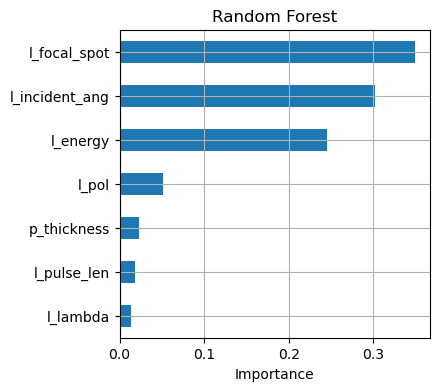

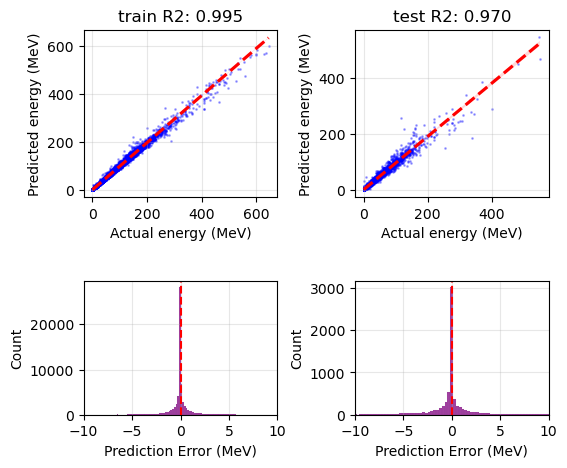

In [16]:
steps = [
  ('rescale', MinMaxScaler()),
  ('rf', RandomForestRegressor(n_estimators=100, random_state=42))
]

model = Pipeline(steps)
model.fit(X_train, y_train)

train_mae, train_mse, train_r2, test_mae, test_mse, test_r2 = train_test_score(model, X_train, y_train, X_test, y_test)

df_importance = pd.DataFrame({'feature': X_train.columns,
    'importance': model.steps[len(steps)-1][1].feature_importances_})
df_importance_sorted = df_importance.sort_values(by='importance', ascending=True)
df_importance_sorted.set_index('feature')['importance'].plot(kind='barh', figsize=(4,4), xlabel='Importance',ylabel='', title='Random Forest')
plt.grid(which='both')

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
visualize_prediction(y_train_pred, train_r2, y_test_pred, test_r2)

# 2. XGBoost

In [3]:
data_URL = "H_Emax_data.csv"
df = pd.read_csv(data_URL)

features = list(df.columns)
target = 'max_energy'
features.remove(target)

X = df[features]
y = df[target]

# Split Train, Test (Validation split is done later during training)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

train MAE: 2.13e+00
train MSE: 1.66e+01
train R2: 0.989
-----------
train MAE: 2.64e+00
train MSE: 3.60e+01
train R2: 0.976


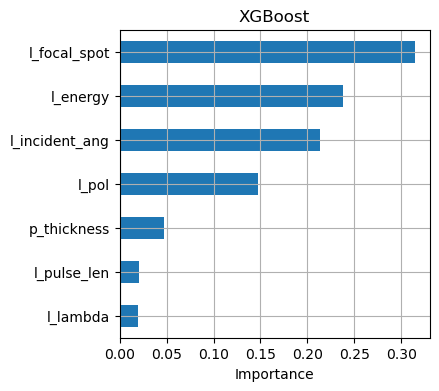

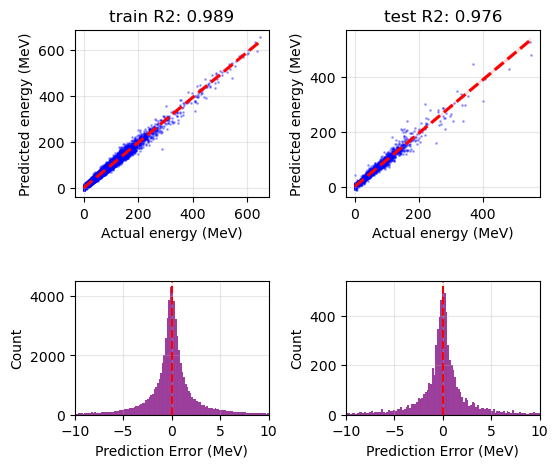

In [17]:
steps = [
  ('rescale', MinMaxScaler()),
  ('xgb', XGBRegressor(random_state=42))
]

model = Pipeline(steps)
model.fit(X_train, y_train)

train_mae, train_mse, train_r2, test_mae, test_mse, test_r2 = train_test_score(model, X_train, y_train, X_test, y_test)

df_importance = pd.DataFrame({'feature': X_train.columns,
    'importance': model.steps[len(steps)-1][1].feature_importances_})
df_importance_sorted = df_importance.sort_values(by='importance', ascending=True)
df_importance_sorted.set_index('feature')['importance'].plot(kind='barh', figsize=(4,4), xlabel='Importance',ylabel='', title='XGBoost')
plt.grid(which='both')

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
visualize_prediction(y_train_pred, train_r2, y_test_pred, test_r2)

# 3. Deep learning 

## Model definition and hyperparameter optimization 

Here, we will define a fully-connected network model which finds its best architecture and regularization using Keras Tuner. The architecture is optimized first, and then the regularization is done in the same way by using the previously determined architecture.

In [4]:
data_URL = "H_Emax_data.csv"
df = pd.read_csv(data_URL)
df.head()

,l_energy,l_focal_spot,l_pulse_len,l_pol,l_incident_ang,l_lambda,p_thickness,max_energy
0,9.545334,0.000015,1.077861e-13,1.0,45.881761,7.000000e-07,2.000000e-06,6.416713
1,8.016723,0.000009,4.399976e-14,1.0,59.937871,6.700000e-07,1.000000e-06,0.302543
2,45.828714,0.000010,7.900063e-14,0.0,35.452565,8.500000e-07,1.500000e-06,14.347128
3,0.834122,0.000016,6.632813e-14,0.0,35.186522,9.800000e-07,6.000000e-07,0.041290
4,2.939410,0.000009,1.808213e-14,0.0,10.175063,8.500000e-07,1.500000e-06,3.193800


In [5]:
df.shape

(74517, 8)

In [6]:
# Convert data to a numpy array
data = df.to_numpy()

In [7]:
# extract features (laser & plasma parameters) and 
# target (max cutoff energy in the proton beam spectrum)
x = data[:,:7]
y = data[:,-1]
y = y.reshape((-1,1))

In [8]:
"""
Scale features by using the maximum values defined in the sample space.
"""
x[:, 0] = x[:, 0] / 50 # Energy
x[:, 1] = x[:, 1] / 20e-6 # Focus-FWHM
x[:, 2] = x[:, 2] / 150e-15 # Pulse length
# x[:, 3]  # laser polarization (0,1), no need to rescale
x[:, 4] = x[:, 4] / 85 # Incidence angle
x[:, 5] = x[:, 5] / 1100e-9 # Wavelength
x[:, 6] = x[:, 6] / 3e-6 # Target thickness

In [9]:
# Split Train, Test (Validation split is done later during training)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)

In [10]:
x_train.shape, x_test.shape

((67065, 7), (7452, 7))

In [15]:
l1 = keras.regularizers.l1(l1=1e-9)
l2 = keras.regularizers.l2(l2=5e-9)

best_model_savepath = 'H_Emax_best_model.h5'

callbacks = [
    # Saves the model to filepath whenever the validation loss improves.
    # Only the best model (lowest val_loss) is saved.
    keras.callbacks.ModelCheckpoint(
        filepath=best_model_savepath, save_best_only=True, monitor="val_loss"
    ),
    # write raining logs to log_dir, 
    # which Lets you visualize: 
    # Loss/metrics over epochs, Learning rate, Computational graph
    tf.keras.callbacks.TensorBoard(log_dir="./logs"), 
    # Monitors val_loss. If val_loss doesn’t improve for 2 epochs, 
    # it reduces the learning rate (lr) by a factor of 0.5.
    # Won’t reduce below min_lr=0.0001.
    # Purpose: Prevents the optimizer from overshooting local minima.
    # - Lets you start with a higher learning rate (fast convergence), then fine-tune.
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=2, min_lr=0.0001
    ),  
    # Stops training early if val_loss doesn't improve for 3 consecutive epochs.
    # NOTICE: - This won’t stop the hyperparameter tuning — just the training of the current model.
    # Purpose: - Prevents overfitting and saves training time.
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, verbose=1),
]


In [16]:
# This creates an instance of the `HyperParameters` class. This object is used to define and manage the search space for hyperparameters during tuning.
HPS = keras_tuner.HyperParameters()

# find best architecture

# During tuning, keras_tuner will try values like 5, 6, 7, or 8 for the number of layers in the neural network to find which performs best.
HPS.Int("num_layers", 4, 6, default=4)

# This loop defines **8 separate hyperparameters**: `"units_0"`, `"units_1"`, ..., `"units_7"`.
# Each one represents the number of units (neurons) in a potential layer of the model and is:
# - An integer between 128 and 512,
# - With step size of 32 (i.e., values could be 128, 160, 192, ..., 512).
# - If `num_layers` = 5,
# - Then the model may use `units_0` to `units_4` only.
# These values will later be used when building a model in a `build_model(hp)` function during the hyperparameter search process.
for i in range(6):
    HPS.Int("units_" + str(i), min_value=32, max_value=128, step=32)


# defines a neural network model whose architecture is dynamically built using hyperparameters. 
# It is meant to be used with Keras Tuner to search for the best model structure
def build_model(hp):
    # - Creates the **input layer**.
    # - The input shape matches the number of features (columns) in the training data `x_train`.
    input_layer = keras.layers.Input(shape=(x_train.shape[1],))
    # Initializes a variable layer to point to the current layer in the model — initially the input layer.
    # This is the base for adding more layers on top.
    layer = input_layer

    # - Adds a series of `Dense` (fully connected) layers on top of each other.
    # - Number of layers is defined by `hp.get("num_layers")` (tuned between 5–8).
    # - Each layer’s number of units is also a tunable hyperparameter: `"units_0"`, `"units_1"`, ..., as defined earlier.
    # - Each hidden layer uses the **ReLU** activation function.
    for i in range(hp.get("num_layers")):
        layer = keras.layers.Dense(units=hp.get("units_" + str(i)), activation="relu")(
            layer
        )

    # Adds the output layer.
    # Number of output units matches the number of target variables (i.e., number of columns in y_train).
    # No activation is specified — which is appropriate for regression tasks (e.g., predicting continuous values).
    output_layer = keras.layers.Dense(y_train.shape[1])(layer)

    # - Constructs the full model from input to output.
    model = keras.models.Model(inputs=input_layer, outputs=output_layer)
    # Optimizer: Adam (adaptive optimizer commonly used).
    # Loss: Mean Squared Error — good for regression problems.
    # Metrics: Also using MSE to monitor performance.
    model.compile(
        optimizer="adam",
        loss=keras.losses.MeanSquaredError(),
        metrics=[keras.metrics.MeanSquaredError()],
    )
    # - Prints the model architecture to the console/logs.
    model.summary()
    # Returns the compiled model to Keras Tuner for training and evaluation with specific hyperparameters.
    return model

# This enables multi-GPU training by distributing the model across all available GPUs on the same machine.
# MirroredStrategy mirrors the model’s variables on each GPU device.
# Each GPU processes a portion of the batch (called data parallelism).
# Gradients from each GPU are synchronized and averaged.
# If you don’t have multiple GPUs, it still works (with one GPU or even CPU), but won’t speed up training.
distribution_strategy = tf.distribute.MirroredStrategy()

# This initializes the **Bayesian Optimization search** for hyperparameters using Keras Tuner.
# Grid Search	Tries all combinations (slow, inefficient)
# Random Search	Tries random combinations uniformly
# Bayesian Opt.	Tries smart combinations using knowledge from past trials
tuner = BayesianOptimization(
    build_model, # The model-building function defined earlier
    objective="val_mean_squared_error", # The metric to minimize during tuning (validation MSE).
    hyperparameters=HPS, # The `HyperParameters` object defining the search space.
    max_trials=10, # Try at most xx different sets of hyperparameters. 
    executions_per_trial=10, # For each trial (i.e., hyperparameter set), train and evaluate the model **10 
                              # times** (with the same training/validation split), and then averages the performance metric (e.g. validation MSE) across the 10 runs. 
                              # Purpose: Reduce randomness from weight initialization, stochastic training, etc.
                              # Different from 10-fold cross validation which split the train dataset into 10 different train/validation splits.
    max_consecutive_failed_trials=10, # stop the tuning  if xx trials in a row fail (e.g., bad hyperparams)
    overwrite=False, # `False`: resumes from existing tuning logs if they exist; `True`: starts fresh.
    directory='.', # Where to store tuning logs and saved models 
    project_name='trials', # Folder name to save results 
)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 7)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,457 (13.50 KB)

 Trainable params: 3,457 (13.50 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Prints a summary of the hyperparameter search space 
tuner.search_space_summary()

batch_size = 256
epochs = 1000

# actual hyperparameter tuning
tuner.search(
    x_train,
    y_train,
    # batch size for training
    batch_size=batch_size,
    # Maximum number of epochs to train per model.
    # Actual training may stop early if EarlyStopping is in callbacks.
    epochs=epochs,
    # Keras callbacks to control training. 
    # Example: EarlyStopping, ReduceLROnPlateau, ModelCheckpoint.
    callbacks=callbacks, 
    # further split a portion of the train set to be used for validation
    validation_split=0.1,  
)

Trial 10 Complete [00h 02m 03s]
val_mean_squared_error: 25.66765594482422

Best val_mean_squared_error So Far: 25.66765594482422
Total elapsed time: 00h 15m 55s


In [18]:
tuner.results_summary(1)
best_model = tuner.get_best_models(1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]

# References to best trial assets
best_trial_id = tuner.oracle.get_best_trials(1)[0].trial_id
best_trial_dir = tuner.get_trial_dir(best_trial_id)

Results summary
Results in ./trials
Showing 1 best trials
Objective(name="val_mean_squared_error", direction="min")

Trial 09 summary
Hyperparameters:
num_layers: 6
units_0: 128
units_1: 64
units_2: 96
units_3: 96
units_4: 128
units_5: 128
Score: 25.66765594482422


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 7)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 96)             │         6,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 96)             │         9,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,889 (210.50 KB)

 Trainable params: 53,889 (210.50 KB)

 Non-trainable params: 0 (0.00 B)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


We can now save our best model if we like

In [ ]:
# best_model.save("H_Emax_best_model.h5")

## Refined tuning with regularization

To obtain the best model with regularization we re-define the `build_model` function with the architecture that we found from the previous hyperparameter search:

In [24]:
HPS.Float("l1_val", min_value=1e-9, max_value=1.0, sampling="log")
HPS.Float("l2_val", min_value=1e-9, max_value=1.0, sampling="log")

1e-09

In [25]:
def build_model(hp):
    input_layer = keras.layers.Input(x_train.shape[1])
    layer = input_layer
    layer = keras.layers.Dense(
        units=416,
        activation="relu",
        kernel_regularizer=keras.regularizers.l1_l2(
            l1=hp.get("l1_val"), l2=hp.get("l2_val")
        ),
    )(layer)
    layer = keras.layers.Dense(
        units=480,
        activation="relu",
        kernel_regularizer=keras.regularizers.l1_l2(
            l1=hp.get("l1_val"), l2=hp.get("l2_val")
        ),
    )(layer)
    layer = keras.layers.Dense(
        units=192,
        activation="relu",
        kernel_regularizer=keras.regularizers.l1_l2(
            l1=hp.get("l1_val"), l2=hp.get("l2_val")
        ),
    )(layer)
    layer = keras.layers.Dense(
        units=512,
        activation="relu",
        kernel_regularizer=keras.regularizers.l1_l2(
            l1=hp.get("l1_val"), l2=hp.get("l2_val")
        ),
    )(layer)
    layer = keras.layers.Dense(
        units=352,
        activation="relu",
        kernel_regularizer=keras.regularizers.l1_l2(
            l1=hp.get("l1_val"), l2=hp.get("l2_val")
        ),
    )(layer)
    layer = keras.layers.Dense(
        units=384,
        activation="relu",
        kernel_regularizer=keras.regularizers.l1_l2(
            l1=hp.get("l1_val"), l2=hp.get("l2_val")
        ),
    )(layer)

    output_layer = keras.layers.Dense(y_train.shape[1])(layer)

    model = keras.models.Model(inputs=input_layer, outputs=output_layer)
    model.compile(
        optimizer="adam",
        loss=keras.losses.MeanSquaredError(),
        metrics=[keras.metrics.MeanSquaredError()],
    )
    model.summary()
    return model

Now we can search the same way as before

In [26]:
tuner.search_space_summary()
tuner.search(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.1,
)

Trial 21 Complete [00h 15m 34s]
val_mean_squared_error: 31.06138381958008

Best val_mean_squared_error So Far: 23.50138568878174
Total elapsed time: 02h 30m 49s


In [ ]:
tuner.results_summary(1)
best_model = tuner.get_best_models(1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]

# References to best trial assets
best_trial_id = tuner.oracle.get_best_trials(1)[0].trial_id
best_trial_dir = tuner.get_trial_dir(best_trial_id)

Now we can save our new best model that is fully optimized:

In [ ]:
# best_model.save("H_Emax_best_model_regularization.h5")

## Model evaluation

In [4]:
data_URL = "H_Emax_data.csv"
df = pd.read_csv(data_URL)

# Convert data to a numpy array
data = df.to_numpy()

# extract features (laser & plasma parameters) and 
# target (max cutoff energy in the proton beam spectrum)
x = data[:,:7]
y = data[:,-1]
y = y.reshape((-1,1))

# Scale features by using the maximum values defined in the sample space.
x[:, 0] = x[:, 0] / 50 # Energy
x[:, 1] = x[:, 1] / 20e-6 # Focus-FWHM
x[:, 2] = x[:, 2] / 150e-15 # Pulse length
# x[:, 3]  # laser polarization (0,1), no need to rescale
x[:, 4] = x[:, 4] / 85 # Incidence angle
x[:, 5] = x[:, 5] / 1100e-9 # Wavelength
x[:, 6] = x[:, 6] / 3e-6 # Target thickness

# Split Train, Test (Validation split is done later during training)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)

In [5]:
model_dl = keras.models.load_model("H_Emax_best_model.h5")

In [12]:
model = model_dl

In [14]:
y_train_pred = model.predict(x_train)

2096/2096 ━━━━━━━━━━━━━━━━━━━━ 1s 332us/step


In [15]:
y_test_pred = model.predict(x_test)

233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step


In [16]:
x_train.shape, x_test.shape

((67065, 7), (7452, 7))

In [33]:
y_train_pred = model.predict(x_train)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
print('train MAE: %.2e'%train_mae)
print('train MSE: %.2e'%train_mse)
print('train R2: %.3f'%train_r2)
print('-----------')
y_test_pred = model.predict(x_test)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)
print('train MAE: %.2e'%test_mae)
print('train MSE: %.2e'%test_mse)
print('train R2: %.3f'%test_r2)


2096/2096 ━━━━━━━━━━━━━━━━━━━━ 1s 297us/step
train MAE: 2.23e+00
train MSE: 3.11e+01
train R2: 0.980
-----------
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step
train MAE: 2.26e+00
train MSE: 3.04e+01
train R2: 0.981


2096/2096 ━━━━━━━━━━━━━━━━━━━━ 1s 305us/step
train MAE: 2.24e+00
train MSE: 3.12e+01
train R2: 0.980
-----------
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step
train MAE: 2.22e+00
train MSE: 2.95e+01
train R2: 0.982
2096/2096 ━━━━━━━━━━━━━━━━━━━━ 1s 307us/step
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step


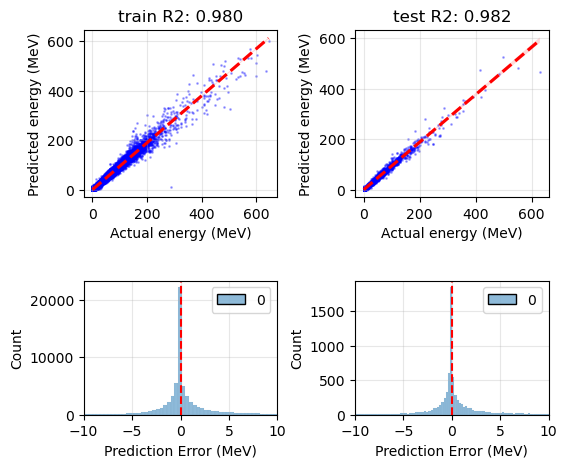

In [10]:
train_mae, train_mse, train_r2, test_mae, test_mse, test_r2 = train_test_score(model_dl, x_train, y_train, x_test, y_test)

y_train_pred = model_dl.predict(x_train)
y_test_pred = model_dl.predict(x_test)
visualize_prediction(y_train_pred, train_r2, y_test_pred, test_r2)

In [ ]:

# Setup the sobol analysis
# Define the model inputs
problem = {
    "num_vars": 7,
    "names": ["EL", "FWHM", "TauL", "Pol", "Theta", "lambda", "dT"],
    "bounds": [[0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1]],  # pol
}
# Generate samples
param_values = sample.sample(problem, 16 * 16384, calc_second_order=True)
# param_values.shape
# Round polarization value
param_values[:, 3] = np.around(param_values[:, 3])
# Run model
Y = model_dl(param_values).numpy().flatten()


# Perform analysis
Si = sobol.analyze(problem, Y, print_to_console=True)
# Print the first-order sensitivity indices
# print(param_values)

/opt/anaconda3/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


              ST   ST_conf
EL      0.165588  0.003757
FWHM    0.859764  0.013196
TauL    0.020273  0.000587
Pol     0.050210  0.001434
Theta   0.402996  0.010130
lambda  0.014008  0.000450
dT      0.042449  0.001385
              S1   S1_conf
EL      0.026728  0.001944
FWHM    0.439361  0.010716
TauL    0.001269  0.000733
Pol     0.006404  0.001132
Theta   0.074770  0.003449
lambda  0.000022  0.000646
dT      0.001986  0.001081
                       S2   S2_conf
(EL, FWHM)       0.074691  0.006668
(EL, TauL)       0.000085  0.003365
(EL, Pol)        0.001080  0.003413
(EL, Theta)      0.013743  0.003645
(EL, lambda)    -0.000094  0.003418
(EL, dT)         0.000207  0.003466
(FWHM, TauL)     0.005040  0.016568
(FWHM, Pol)      0.015203  0.017597
(FWHM, Theta)    0.223368  0.022336
(FWHM, lambda)   0.000657  0.016833
(FWHM, dT)       0.014193  0.016785
(TauL, Pol)      0.000363  0.001224
(TauL, Theta)    0.001906  0.001421
(TauL, lambda)   0.000303  0.001196
(TauL, dT)       0.000278  0

In [ ]:

# function to round result to significant digits
def round_to_1(x, refx):
    return round(x, -int(floor(log10(abs(refx)))))

<>:31: SyntaxWarning: invalid escape sequence '\p'
<>:31: SyntaxWarning: invalid escape sequence '\p'
/var/folders/g1/_35pwh893r3ffwtp9yc16yl00000gp/T/ipykernel_14621/344202404.py:31: SyntaxWarning: invalid escape sequence '\p'
  labeling = r"$" + str(mean[i]) + "\pm" + str(sigma[i]) + "$"


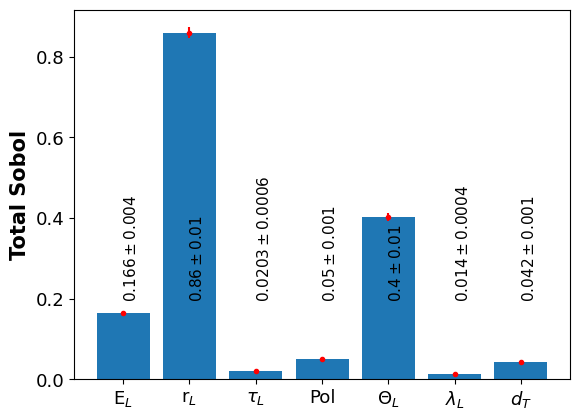

In [ ]:
# Plot the total Sobol variation plot.
# calculate the mean and sigma for display
sigma = [round_to_1(Si["ST_conf"][i], Si["ST_conf"][i]) for i in range(problem["num_vars"])]
mean  = [round_to_1(Si["ST"][i], Si["ST_conf"][i]) for i in range(problem["num_vars"])]

plt.figure(dpi=100)
plt.rcParams["font.size"] = "13"

# set x axis params:
x = [i for i in range(problem["num_vars"])]
# step 1: plot the bar chart
plt.bar(x, Si["ST"])
# step 2: plot the errorbar
plt.errorbar(x, Si["ST"], yerr=Si["ST_conf"], fmt=".", color="r")

# step 3: adjust tick labeling
plot_labels = [
    r"E$_L$",
    r"r$_L$",
    r"$\tau_L$",
    r"Pol",
    r"$\Theta_L$",
    r"$\lambda_L$",
    r"$d_T$",
]

plot_labels = plot_labels[7 - problem["num_vars"] :]
plt.xticks(x, labels=plot_labels)
plt.ylabel("Total Sobol", fontsize=15, weight="bold")
for i in range(problem["num_vars"]):
    labeling = r"$" + str(mean[i]) + "\pm" + str(sigma[i]) + "$"
    plt.text(x[i], 0.2, labeling, fontsize=11, rotation=90)


# 4. Model comparison

Model performance
- DL has the best performance (R2~0.98) and generalization (train/test result very close) 

Interpretability
- All 3 models (Random Forest, XGBoost, Deep Learning) have similar feature importance ranking.
- Deep Learning's feature ranking is particularly close to that of Random Forest. 